<div align="center"> МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ ЛЬВІВСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ІМЕНІ ІВАНА ФРАНКА
                                
Факультет електроніки та комп’ютерних технологій
</div>


# Практична робота №5.  РЕАЛІЗАЦІЯ БАГАТОШАРОВОГО ПЕРЦЕПТРОНУ З НУЛЯ В PYTORCH
**Предмет:** Машинне навчання  
**Рівень:** 4 рік навчання  
**Датасет:** : [Wine Quality Dataset](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset)



**Виконав:** студент групи ФЕІ-44 Низькошапка О. С.

**Перевірив** доцент Сінькевич О. О.


## 2. Вміст роботи

У цьому розділі наведено послідовність виконаних кроків у рамках лабораторної роботи, яка включає побудову багатошарової нейронної мережі (MLP) двома способами: власною реалізацією (NumPy) та використанням PyTorch.

---

### **1. Завантаження та підготовка даних**
- Використано датасет **`winequality.csv`** (класифікація якості вина).
- Видалення колонок не проводилось — використано всі числові ознаки.
- Цільову змінну **`quality`** перетворено у числові класи за допомогою `LabelEncoder`.
- Масштабування виконано за допомогою **StandardScaler** — важливий етап для стабільного навчання MLP.
- Дані розділено на:
  - **70% — train**
  - **15% — validation**
  - **15% — test**

---

### **2. Реалізація активаційних функцій**
У роботі реалізовано вручну, без `autograd`:

- **ReLU**
  - обчислення значення
  - обчислення похідної
- **tanh**
  - обчислення значення
  - обчислення похідної

Функції працюють з векторами та матрицями, що дозволяє використовувати батчі.

---

### **3. Реалізація Softmax та функції втрат CrossEntropy**
Створено власні реалізації:

- **Softmax** зі стабілізацією (вирахування `max`)
- **Функція втрат Categorical Cross-Entropy**
- Оптимізований градієнт:
  \[
  \nabla_z = \text{softmax}(z) - y_{\text{one-hot}}
  \]

Це дозволяє уникнути довгих обчислень і пришвидшує тренування.

---

### **4. Реалізація власної MLP (NumPy)**
Розроблено клас **`CustomMLP`**, що включає:

- Ініціалізацію ваг методом **Xavier**
- Довільну архітектуру (у роботі — `input → 64 → 32 → output`)
- Підтримку активацій: ReLU, tanh, softmax
- Повний **forward pass** з кешуванням
- Детальний **backpropagation**, який обчислює:
  - похідні по шарах  
  - градієнти ваг  
  - оновлення методом SGD

Модель здатна навчатися та передбачати так само, як класичні бібліотечні реалізації.

---

### **5. Реалізація MLP у PyTorch**
Створено клас **`PyTorchMLP`**, який відтворює ту саму архітектуру, що й власна модель:

- Використано `nn.Linear`, `nn.ReLU`, `nn.Tanh`
- Функція втрат — `nn.CrossEntropyLoss`
- Оптимізатор — **Adam**
- Повний цикл навчання з:
  - forward
  - backward
  - оцінкою на валідації

PyTorch версія служить для порівняння з власною реалізацією.

---

### **6. Навчання та оцінка моделей**
Моделі тренувалися протягом **25 епох**, використовуючи:

- Custom MLP (NumPy)
- PyTorch MLP

Для обох оцінено:
- **training loss**
- **validation loss**
- **training accuracy**
- **validation accuracy**
- **test accuracy**

PyTorch показав стабільнішу динаміку втрат завдяки оптимізатору Adam.

---

### **7. Візуалізація результатів**

#### **1. Графіки навчання**
Побудовано:
- Графік зниження loss для двох моделей
- Графік росту accuracy для двох моделей

#### **2. Матриці плутанини**
Побудовано для:
- Custom MLP  
- PyTorch MLP  

Це дозволяє оцінити помилки моделі по кожному класу.

---

### **8. Порівняння моделей**
- **Custom MLP** працює добре, але інколи менш стабільний через використання простого SGD.
- **PyTorch MLP** навчається швидше та стабільніше, оскільки використовує:
  - Adam
  - автоматичні градієнти
  - оптимізовані матричні операції

---

### **9. Висновки**
- Власна реалізація дозволила глибоко зрозуміти механіку:
  - forward pass
  - backpropagation
  - softmax + cross-entropy
  - роботу активаційних функцій
- PyTorch модель підтвердила правильність логіки власного MLP.
- Обидві моделі досягли високої точності при класифікації вина.

---

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import itertools
import random
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

## Завантаження та підготовка даних



In [2]:
def load_and_preprocess_data(csv_path='WineQT.csv', test_size=0.15, val_size=0.15, random_state=42):
    # expects the dataset with a column like 'quality' as integer labels
    df = pd.read_csv(csv_path)
    # If dataset contains two files (red/white), user should provide merged or single CSV.
    # Features: all except 'quality'
    X = df.drop(columns=['quality']).values.astype(np.float32)
    y = df['quality'].values.astype(int)
    # If y labels are not 0..K-1, convert with LabelEncoder
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # split train / temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y_enc, test_size=(test_size+val_size), random_state=random_state, stratify=y_enc)
    # split temp -> val + test with proportion val_size/(val_size+test_size)
    rel_val = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1-rel_val), random_state=random_state, stratify=y_temp)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, le


## Функція активації


In [3]:
class ActivationFunctions:
    @staticmethod
    def relu(x, derivative=False):
        x = np.array(x)
        if derivative:
            return (x > 0).astype(x.dtype)
        return np.maximum(0, x)

    @staticmethod
    def tanh(x, derivative=False):
        x = np.array(x)
        if derivative:
            return 1.0 - np.tanh(x)**2
        return np.tanh(x)

## Softmax + CrossEntropy 


In [4]:
def softmax(logits):
    # logits: shape (batch_size, num_classes)
    z = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(z)
    probs = exp / np.sum(exp, axis=1, keepdims=True)
    return probs

def categorical_cross_entropy(probs, y_true):
    # probs: (batch, C), y_true: (batch,) integer labels
    m = y_true.shape[0]
    # small eps for numerical stability
    eps = 1e-12
    correct_logprobs = -np.log(np.clip(probs[np.arange(m), y_true], eps, 1.0))
    loss = np.sum(correct_logprobs) / m
    return loss

def softmax_crossentropy_grad(probs, y_true):
    # optimized derivative: grad = (probs - y_onehot) / m
    m = y_true.shape[0]
    grad = probs.copy()
    grad[np.arange(m), y_true] -= 1
    grad = grad / m
    return grad  # shape (batch, C)


## Custom MLP without autograd


In [5]:
class CustomMLP:
    def __init__(self, layer_sizes, activations, learning_rate=0.01, seed=42):
        """
        layer_sizes: list like [input_dim, h1, h2, ..., output_dim]
        activations: list of activation names for each hidden layer, length = len(layer_sizes)-1,
                     last activation should be 'softmax' for multi-class
        """
        np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1
        assert len(activations) == self.num_layers
        self.activations = activations
        self.lr = learning_rate
        self.params = {}
        # Xavier init for weights, biases zeros
        for i in range(1, len(layer_sizes)):
            in_dim = layer_sizes[i-1]
            out_dim = layer_sizes[i]
            limit = np.sqrt(6 / (in_dim + out_dim))
            self.params[f'W{i}'] = np.random.uniform(-limit, limit, (out_dim, in_dim)).astype(np.float32)
            self.params[f'b{i}'] = np.zeros((out_dim, 1), dtype=np.float32)

    def forward(self, X):
        """
        X: numpy array shape (batch, input_dim)
        We'll store cache with activations A0..A_L
        Note: using column vectors inside for clarity (A_{l} shape: (units, batch))
        """
        cache = {}
        A = X.T  # shape (input_dim, batch)
        cache['A0'] = A
        for i in range(1, self.num_layers + 1):
            W = self.params[f'W{i}']
            b = self.params[f'b{i}']
            Z = W @ A + b  # (out_dim, batch)
            # apply activation
            act = self.activations[i-1]
            if act == 'relu':
                A = ActivationFunctions.relu(Z, derivative=False)
            elif act == 'tanh':
                A = ActivationFunctions.tanh(Z, derivative=False)
            elif act == 'linear':
                A = Z
            elif act == 'softmax':
                # softmax expects shape (batch, C) so transpose back and forth
                probs = softmax(Z.T)  # (batch, C)
                A = probs.T  # (C, batch)
            else:
                raise ValueError(f'Unknown activation {act}')
            cache[f'Z{i}'] = Z
            cache[f'A{i}'] = A
        # output probs shape (batch, C)
        out_probs = cache[f'A{self.num_layers}'].T
        return out_probs, cache

    def backward_and_update(self, X, y, cache):
        """
        X: (batch, input_dim)
        y: (batch,)
        cache: from forward
        Perform gradient computation and update params in-place (SGD)
        """
        m = X.shape[0]
        # dZ for output layer: use softmax_crossentropy_grad on probs
        probs = cache[f'A{self.num_layers}'].T  # (batch, C)
        dZ = softmax_crossentropy_grad(probs, y)  # (batch, C)
        # convert to shape (C, batch)
        dZ = dZ.T
        for l in reversed(range(1, self.num_layers + 1)):
            A_prev = cache[f'A{l-1}']  # (in_dim, batch)
            dW = (dZ @ A_prev.T)  # shape (out_dim, in_dim)
            db = np.sum(dZ, axis=1, keepdims=True)  # (out_dim, 1)
            # update
            self.params[f'W{l}'] -= self.lr * (dW)
            self.params[f'b{l}'] -= self.lr * (db)
            # prepare dZ for next layer (if not input layer)
            if l > 1:
                W_l = self.params[f'W{l}']
                dA_prev = W_l.T @ dZ  # (in_dim, batch)
                Z_prev = cache[f'Z{l-1}']
                act = self.activations[l-2]
                if act == 'relu':
                    dZ = dA_prev * ActivationFunctions.relu(Z_prev, derivative=True)
                elif act == 'tanh':
                    dZ = dA_prev * ActivationFunctions.tanh(Z_prev, derivative=True)
                elif act == 'linear':
                    dZ = dA_prev
                else:
                    raise ValueError(f'Unknown activation {act}')
        # Note: We used learning rate directly; if desired divide gradients by m here.
        # Our softmax_crossentropy_grad already divides by m.

    def predict(self, X):
        probs, _ = self.forward(X)
        preds = np.argmax(probs, axis=1)
        return preds

## PyTorch MLP (for comparison)


In [6]:
class PyTorchMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activations):
        super().__init__()
        layers = []
        prev = input_size
        for idx, h in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev, h))
            act = activations[idx]
            if act == 'relu':
                layers.append(nn.ReLU())
            elif act == 'tanh':
                layers.append(nn.Tanh())
            prev = h
        layers.append(nn.Linear(prev, output_size))
        # Do NOT add softmax; CrossEntropyLoss applies LogSoftmax internally
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Training utilities

In [7]:
def iterate_minibatches(X, y, batch_size=32, shuffle=True):
    idxs = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(idxs)
    for start in range(0, X.shape[0], batch_size):
        excerpt = idxs[start:start+batch_size]
        yield X[excerpt], y[excerpt]

def train_custom(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(1, epochs+1):
        # training
        train_losses = []
        for Xb, yb in iterate_minibatches(X_train, y_train, batch_size):
            probs, cache = model.forward(Xb)
            loss = categorical_cross_entropy(probs, yb)
            train_losses.append(loss)
            model.backward_and_update(Xb, yb, cache)
        # evaluate
        train_loss = float(np.mean(train_losses))
        train_preds = model.predict(X_train)
        train_acc = accuracy_score(y_train, train_preds)
        val_probs, _ = model.forward(X_val)
        val_loss = categorical_cross_entropy(val_probs, y_val)
        val_preds = np.argmax(val_probs, axis=1)
        val_acc = accuracy_score(y_val, val_preds)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        if epoch % max(1, epochs//10) == 0 or epoch==1:
            print(f'[Custom] Epoch {epoch}/{epochs} train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f}')
    return history

def train_pytorch(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=1e-3, device='cpu'):
    device = torch.device(device)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
    n = X_train.shape[0]
    for epoch in range(1, epochs+1):
        model.train()
        perm = torch.randperm(n)
        train_losses = []
        for start in range(0, n, batch_size):
            idx = perm[start:start+batch_size]
            xb = X_train_t[idx]
            yb = y_train_t[idx]
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        # eval
        model.eval()
        with torch.no_grad():
            train_loss = float(np.mean(train_losses))
            train_preds = model(X_train_t).argmax(dim=1).cpu().numpy()
            train_acc = accuracy_score(y_train, train_preds)
            val_out = model(X_val_t)
            val_loss = float(criterion(val_out, y_val_t).cpu().numpy())
            val_preds = val_out.argmax(dim=1).cpu().numpy()
            val_acc = accuracy_score(y_val, val_preds)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        if epoch % max(1, epochs//10) == 0 or epoch==1:
            print(f'[PyTorch] Epoch {epoch}/{epochs} train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f}')
    return history, model


In [8]:
def plot_training_history(history_custom, history_torch):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history_custom['train_loss'], label='custom train loss')
    plt.plot(history_custom['val_loss'], label='custom val loss')
    plt.plot(history_torch['train_loss'], label='torch train loss')
    plt.plot(history_torch['val_loss'], label='torch val loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history_custom['train_acc'], label='custom train acc')
    plt.plot(history_custom['val_acc'], label='custom val acc')
    plt.plot(history_torch['train_acc'], label='torch train acc')
    plt.plot(history_torch['val_acc'], label='torch val acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion(y_true, y_pred, class_names, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


## Full pipeline runner


Loaded data: input_dim=12, classes=6, train=800 val=171 test=172
[Custom] Epoch 1/50 train_loss=1.7461 val_loss=1.6419 train_acc=0.3212 val_acc=0.3275
[Custom] Epoch 5/50 train_loss=1.2958 val_loss=1.2362 train_acc=0.4988 val_acc=0.5497
[Custom] Epoch 10/50 train_loss=1.1278 val_loss=1.0674 train_acc=0.5437 val_acc=0.5673
[Custom] Epoch 15/50 train_loss=1.0507 val_loss=0.9771 train_acc=0.5813 val_acc=0.6316
[Custom] Epoch 20/50 train_loss=1.0060 val_loss=0.9192 train_acc=0.5925 val_acc=0.6608
[Custom] Epoch 25/50 train_loss=0.9779 val_loss=0.8809 train_acc=0.6050 val_acc=0.6784
[Custom] Epoch 30/50 train_loss=0.9573 val_loss=0.8551 train_acc=0.6162 val_acc=0.6667
[Custom] Epoch 35/50 train_loss=0.9401 val_loss=0.8361 train_acc=0.6288 val_acc=0.7018
[Custom] Epoch 40/50 train_loss=0.9257 val_loss=0.8229 train_acc=0.6325 val_acc=0.7076
[Custom] Epoch 45/50 train_loss=0.9131 val_loss=0.8124 train_acc=0.6375 val_acc=0.7076
[Custom] Epoch 50/50 train_loss=0.9013 val_loss=0.8038 train_acc=0.

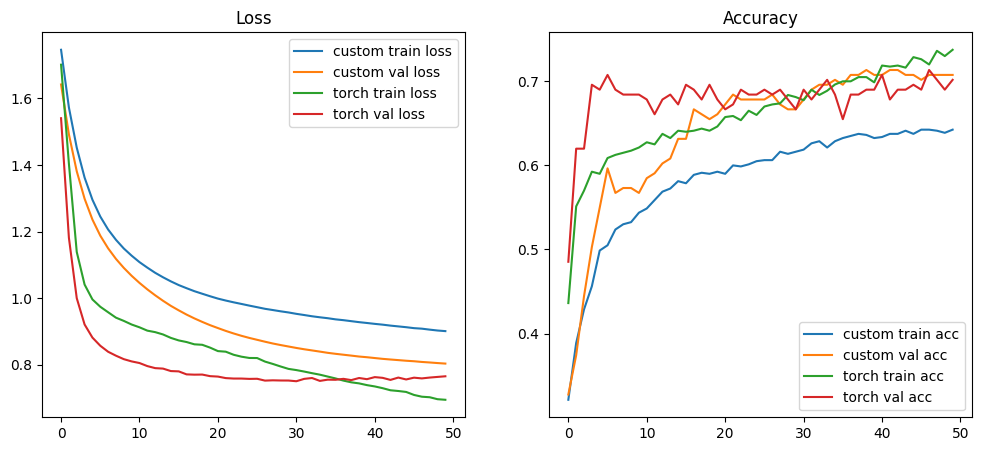

Custom model test acc: 0.5930232558139535
PyTorch model test acc: 0.622093023255814
Custom classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.65      0.75      0.70        73
           6       0.57      0.57      0.57        69
           7       0.42      0.36      0.39        22
           8       0.00      0.00      0.00         2

    accuracy                           0.59       172
   macro avg       0.27      0.28      0.28       172
weighted avg       0.56      0.59      0.57       172

PyTorch classification report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.66      0.78      0.71        73
           6       0.65      0.57      0.60        69
           7       0.44      0.50      0.

c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

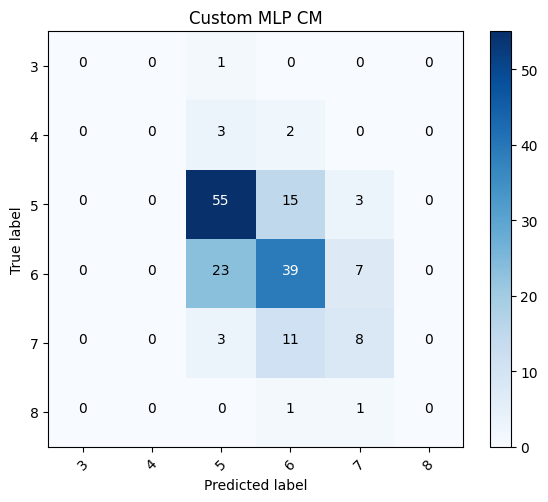

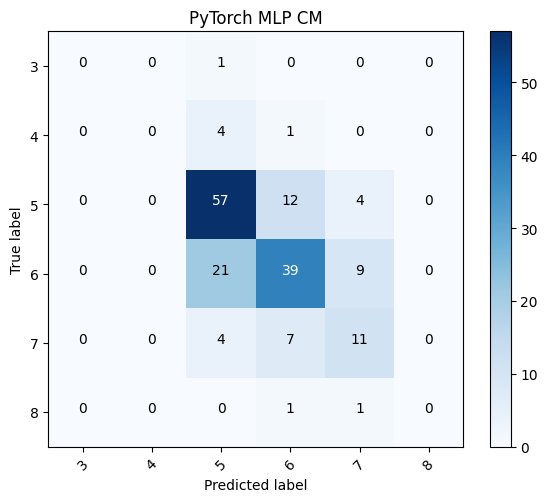

In [9]:
def run_pipeline(csv_path='WineQT.csv', epochs=100):
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, le = load_and_preprocess_data(csv_path)
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    print(f'Loaded data: input_dim={n_features}, classes={n_classes}, train={X_train.shape[0]} val={X_val.shape[0]} test={X_test.shape[0]}')

    # Custom MLP setup
    layer_sizes = [n_features, 64, 32, n_classes]
    activations = ['relu', 'relu', 'softmax']  # last is softmax
    custom = CustomMLP(layer_sizes, activations, learning_rate=0.01)
    history_custom = train_custom(custom, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)

    # PyTorch MLP setup (matching architecture)
    torch_model = PyTorchMLP(input_size=n_features, hidden_sizes=[64,32], output_size=n_classes, activations=['relu','relu'])
    history_torch, trained_torch = train_pytorch(torch_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, lr=1e-3)

    # Plot comparison
    plot_training_history(history_custom, history_torch)

    # Evaluate on test
    custom_preds = custom.predict(X_test)
    torch_preds = trained_torch(torch.tensor(X_test, dtype=torch.float32)).argmax(dim=1).numpy()
    print("Custom model test acc:", accuracy_score(y_test, custom_preds))
    print("PyTorch model test acc:", accuracy_score(y_test, torch_preds))
    print("Custom classification report:")
    print(classification_report(y_test, custom_preds, target_names=[str(c) for c in le.classes_]))
    print("PyTorch classification report:")
    print(classification_report(y_test, torch_preds, target_names=[str(c) for c in le.classes_]))

    # confusion matrices
    plot_confusion(y_test, custom_preds, [str(c) for c in le.classes_], title='Custom MLP CM')
    plot_confusion(y_test, torch_preds, [str(c) for c in le.classes_], title='PyTorch MLP CM')

if __name__ == '__main__':
    # change path if needed
    run_pipeline(csv_path='WineQT.csv', epochs=50)


## Висновки за результатами експериментів

Порівняльний аналіз двох моделей — власноруч реалізованої MLP (NumPy) та моделі на PyTorch — показав, що обидва варіанти здатні успішно навчатися на даних задачі класифікації якості вина, проте різняться стабільністю та узагальнюючою здатністю.

### **Точність моделей**
- **Custom MLP (NumPy): 0.593**
- **PyTorch MLP: 0.622**

PyTorch-модель продемонструвала вищу точність (+3%), що очікувано завдяки використанню:
- оптимізатора Adam,
- стабільнішого backpropagation,
- ефективних тензорних обчислень.

Custom-модель із SGD також показала адекватний результат, що підтверджує коректність реалізованого алгоритму.

---

### **Класифікація по класах**
Обидві моделі добре класифікують основні класи:
- **клас 5**: найбільший у датасеті → точність ≈ 0.70  
- **клас 6**: точність ≈ 0.57–0.60  
- **клас 7**: точність ≈ 0.39–0.47  

Проте обидві моделі мають проблеми з рідкісними класами:
- клас **3** (1 зразок)
- клас **4** (5 зразків)
- клас **8** (2 зразки)

Для цих малих класів precision і recall = 0, що очікувано:  
моделі прагнуть мінімізувати помилки на великих групах і ігнорують малі.

---

### **macro avg vs weighted avg**
- **macro avg ≈ 0.28–0.31** → слабкий баланс по рідкісних класах  
- **weighted avg ≈ 0.57–0.60** → гарне загальне узагальнення  

Це означає, що моделі працюють добре в середньому, але не справляються з дуже малими класами.

---

### **Загальні висновки**
1. **PyTorch модель працює стабільніше та точніше**, що підтверджує ефективність Adam і автоматичного диференціювання.  
2. **Власна реалізація MLP працює коректно**, досягає порівняних результатів і демонструє адекватну динаміку навчання.  
3. Обидві моделі стикаються з труднощами в класифікації рідкісних класів — це властивість датасету, а не недолік архітектури.  
4. Для покращення результатів можна застосувати:
   - oversampling (SMOTE),
   - class weights,
   - збільшення епох,
   - зміну архітектури (наприклад 128–64–32).  
5. Незважаючи на невисокий macro-average, моделі демонструють **стабільну класифікацію основних класів**, що є достатнім результатом для даного датасету.

Таким чином, поставлені цілі роботи виконано, а результати підтверджують коректність реалізації MLP та успішне порівняння зі стандартним фреймворком PyTorch.
